Differential condensability analysis and plots

In [1]:
# python modules
import sys
import copy
import random
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [5]:
def plot_score_scatter (ID_score1,
                        ID_score2,
                        ID_color,
                        IDs=None,
                        standardize_color=True,
                        ID_text={},
                        fig_width=None,
                        fig_height=None,
                        vmin=-5,
                        vmax=5,
                        alpha=0.3,
                        size=2,
                        draw_eqline=True,
                        xlim=[None,None],
                        ylim=[None,None],
                        xlabel='',
                        ylabel='',
                        title=None,
                        cbar_ylabel='',
                        save=False,
                        note=''):

    # custom diverging colormap with white background
    pastel_jet = LinearSegmentedColormap.from_list('white_viridis',
                                                   [(0, 'darkblue'),
                                                    (0.1, 'blue'),
                                                    (0.2, 'tab:blue'),
                                                    (0.4, 'tab:cyan'),
                                                    (0.5, 'ivory'),
                                                    (0.6, 'tab:orange'),
                                                    (0.8, 'tab:red'),
                                                    (0.9, 'red'),
                                                    (1, 'darkred')
                                                    ], N=256)

    all_IDs = set(ID_score1.keys()) & set(ID_score2.keys())

    if IDs == None:
        IDs = all_IDs
    else:
        IDs = all_IDs & set(IDs)

    out_IDs = IDs & set(ID_text.keys())
    IDs -= out_IDs

    IDs = sorted(list(IDs))
    out_IDs = sorted(list(out_IDs))
    
    X, Y = [], []
    C = []
    for ID in IDs:
        X.append(ID_score1[ID])
        Y.append(ID_score2[ID])
        C.append(ID_color[ID])

    if standardize_color:
        C = stats.zscore(C)

    # draw all genes
    if fig_width==None or fig_height==None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=(fig_width,
                                  fig_height))
    
    plt.scatter(X,
                Y,
                c=C,
                cmap=pastel_jet,
                vmin=vmin,
                vmax=vmax,
                alpha=alpha,
                s=size)

    for ID in out_IDs:
        text = ID_text[ID]
        x, y = ID_score1[ID], ID_score2[ID]
        
        plt.plot(x,
                 y,
                 'kx',
                 markersize=6,
                 alpha=1,
                 zorder=10,
                 mew=2)
        
        plt.annotate(text,
                     (x+0.05, y+0.05),
                     color='black',
                     zorder=40,
                     size=10,
                     weight='bold')
        
    if draw_eqline:
        plt.plot([min(X), max(X)],
                 [min(Y), max(Y)],
                 'k--',
                 alpha=0.7)
    
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)

    if title!=None:
        plt.title(title, fontsize=15)

    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cbar_ylabel,
                       rotation=-90,
                       va="bottom")

    if save:
        plt.savefig("score_scatter_%s.png" % (note),
                    bbox_inches='tight',
                    dpi=300)

    plt.tight_layout()
    plt.show()
    plt.close()


In [6]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/GTF/'
GTF_fname = 'ENCFF871VGR.gtf'
geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=cell_chrnames['mCD8T:WT'])

In [7]:
### get near TSS interval for each genes
chr_geneID_interval = {}
for geneID in geneID_field_value:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue
    interval = (pos-2500, pos+2500)

    if chr not in chr_geneID_interval:
        chr_geneID_interval[chr] = {}
    chr_geneID_interval[chr][geneID] = interval

In [8]:
### setting data to load (file-extension, dtype, resolution, rep, cell, sample, agent, tnum)
path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dkey_list = [('score.gtab.gz', 'score', 'single', 1, 'mCD8T:WT', 'NCP', 'sp', 8),
             ('score.gtab.gz', 'score', 'single', 1, 'mCD8T:DFMO', 'NCP', 'sp', 8),
             ('score.gtab.gz', 'score', 'single', 1, 'mCD8T:ODCKO', 'NCP', 'sp', 8)]

In [9]:
### load condense-seq data and get mean score near TSS of genes
dkey_geneID_mscore = {}
for dkey in dkey_list:
    print dkey
    exten, dtype, resol, rep, cell, sample, agent, tnum = dkey

    chr_list = cell_chrnames[cell]

    geneID_mscore = {}
    for chr in chr_list:
        print '\t %s' % (chr)
        
        gtab_fname = '_'.join([cell,
                               sample,
                               agent,
                               str(rep) + 'rep',
                               'deep',
                               chr]) + '_' + exten

        field = '_'.join([cell,
                          sample,
                          agent,
                          str(tnum),
                          str(rep) + 'rep',
                          'deep'])
        
        ID_score = load_file.read_gtab (path + gtab_fname,
                                        mode='col',
                                        field_choices=[field])[field]
        ID_win = {ID:ID[1] for ID in ID_score}
        geneID_interval = chr_geneID_interval[chr]

        geneID_mscore.update(statis.bin_data_mean(geneID_interval,
                                                  ID_win,
                                                  ID_score,
                                                  max_pos=max(ID_win.values()),
                                                  min_sample_size=10,
                                                  skip_nan=True,
                                                  silent=True))

    dkey_geneID_mscore[dkey] = geneID_mscore
    

('score.gtab.gz', 'score', 'single', 1, 'mCD8T:WT', 'NCP', 'sp', 8)
	 chr1


	 chr2


	 chr3


	 chr4


	 chr5


	 chr6


	 chr7


	 chr8


	 chr9


	 chr10


	 chr11


	 chr12


	 chr13


	 chr14


	 chr15


	 chr16


	 chr17


	 chr18


	 chr19


	 chrX


('score.gtab.gz', 'score', 'single', 1, 'mCD8T:DFMO', 'NCP', 'sp', 8)
	 chr1


	 chr2


	 chr3


	 chr4


	 chr5


	 chr6


	 chr7


	 chr8


	 chr9


	 chr10


	 chr11


	 chr12


	 chr13


	 chr14


	 chr15


	 chr16


	 chr17


	 chr18


	 chr19


	 chrX


('score.gtab.gz', 'score', 'single', 1, 'mCD8T:ODCKO', 'NCP', 'sp', 8)
	 chr1


	 chr2


	 chr3


	 chr4


	 chr5


	 chr6


	 chr7


	 chr8


	 chr9


	 chr10


	 chr11


	 chr12


	 chr13


	 chr14


	 chr15


	 chr16


	 chr17


	 chr18


	 chr19


	 chrX


In [10]:
### save the data as pickle
fname = 'mCD8T_geneID_mscore'
pickle.dump(dkey_geneID_mscore, open(fname + ".pickle", "wb"))

In [11]:
### read RNA-seq data and compute FPKM
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/ODC_mouse_RNAseq/30-916504364/hit-counts/'

rep_cell_RNAseq_fname = {1:{'mCD8T:WT':'WT-1.counts.txt',
                            'mCD8T:DFMO':'I-1.counts.txt',
                            'mCD8T:ODCKO':'KO-1.counts.txt'},
                         2:{'mCD8T:WT':'WT-2.counts.txt',
                            'mCD8T:DFMO':'I-2.counts.txt',
                            'mCD8T:ODCKO':'KO-2.counts.txt'},
                         3:{'mCD8T:WT':'WT-3.counts.txt',
                            'mCD8T:DFMO':'I-3.counts.txt',
                            'mCD8T:ODCKO':'KO-3.counts.txt'}}

## compute exon lengths
geneID_exonlen = {}
for geneID in geneID_field_value:
    exons = geneID_field_value[geneID]['exons']
    length = 0
    for start, end in exons:
        length +=  end - start + 1
    geneID_exonlen[geneID] = length

## read read counts
cell_geneID_FPKMs = {}
for rep in sorted(rep_cell_RNAseq_fname):
    cell_RNAseq_fname = rep_cell_RNAseq_fname[rep]
    for cell in sorted(cell_RNAseq_fname):
        RNAseq_fname = cell_RNAseq_fname[cell]
        field = RNAseq_fname.split('.')[0]

        ## get read counts
        geneID_count = load_file.read_tabular_file (RNAseq_path + RNAseq_fname,
                                                    mode="col")[field]

        total_count = 0
        for geneID in geneID_count:
            count = geneID_count[geneID]
            #if count <=0:
            #    continue
            geneID_count[geneID] +=1 # add pseudocount
            total_count += geneID_count[geneID]

        ## compute FPKM
        #geneID_FPKM = {}
        for geneID in geneID_count:
            try:
                FPM = (float(geneID_count[geneID]) / total_count)*(10**6)
                FPKM = float(FPM)/(geneID_exonlen[geneID]/1000.0)
            except:
                continue
            #geneID_FPKM[geneID] = FPKM

            if cell not in cell_geneID_FPKMs:
                cell_geneID_FPKMs[cell] = {}
            if geneID not in cell_geneID_FPKMs[cell]:
                cell_geneID_FPKMs[cell][geneID] = []
            cell_geneID_FPKMs[cell][geneID].append(FPKM)
            #cell_geneID_FPKMs[cell][geneID].append(geneID_count[geneID])

In [12]:
### define common geneIDs
target_geneIDs = set([])
for i in range(len(dkey_list)):
    dkey = dkey_list[i]
    geneID_mscore = dkey_geneID_mscore[dkey]
    geneIDs = set(geneID_mscore.keys())
    if i == 0:
        target_geneIDs |= geneIDs
        continue
    target_geneIDs &= geneIDs
target_geneIDs = sorted(list(target_geneIDs))
print 'Total gene count:' + str(len(target_geneIDs))

Total gene count:53831


In [13]:
### standardize the condensability scores
dkey_geneID_zscore = {}
for dkey in dkey_list:
    geneID_mscore = dkey_geneID_mscore[dkey]
    geneID_zscore = statis.standardize_dict(geneID_mscore,
                                            keys=target_geneIDs)
    dkey_geneID_zscore[dkey] = geneID_zscore

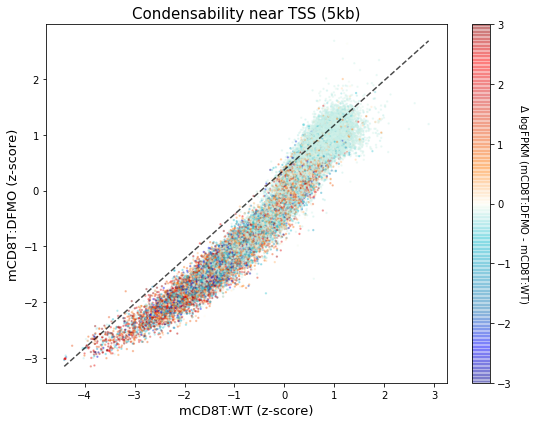

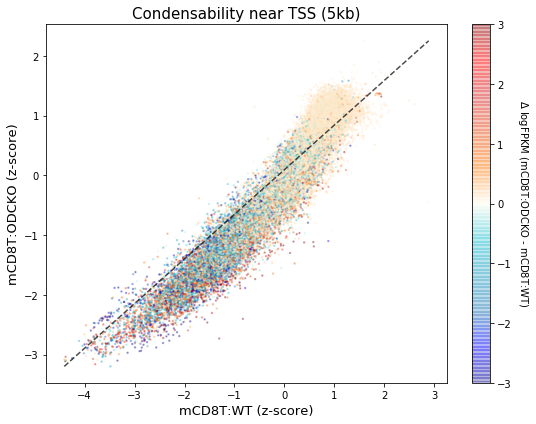

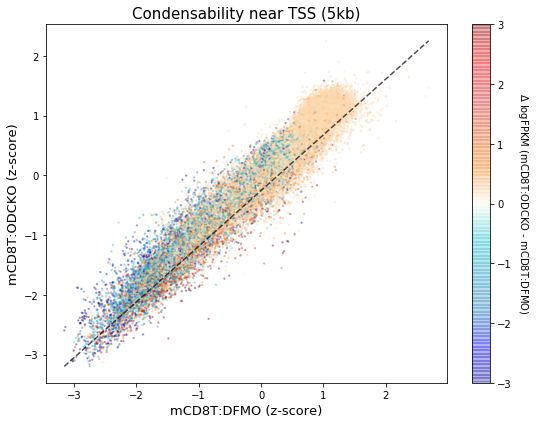

In [37]:
### plot condensability with gene expression differences
for i in range(len(dkey_list)-1):
    for j in range(i+1, len(dkey_list)):
        dkey1 = dkey_list[i]
        dkey2 = dkey_list[j]
        
        geneID_zscore1 = dkey_geneID_zscore[dkey1]
        geneID_zscore2 = dkey_geneID_zscore[dkey2]

        cell1 = dkey1[4]
        cell2 = dkey2[4]
        
        ## compute gene expression differences
        geneID_dlogFPKM = {}
        for geneID in target_geneIDs:
            try:
                FPKM1 = np.nanmean(cell_geneID_FPKMs[cell1][geneID])
                FPKM2 = np.nanmean(cell_geneID_FPKMs[cell2][geneID])
            except:
                continue
            dlogFPKM = np.log2(1+FPKM2) - np.log2(1+FPKM1)
            geneID_dlogFPKM[geneID] = dlogFPKM

        
        ## plot scatter plot
        plot_score_scatter (geneID_zscore1,
                            geneID_zscore2,
                            geneID_dlogFPKM,
                            IDs=list(set(target_geneIDs) & set(geneID_dlogFPKM.keys())),
                            standardize_color=True,
                            #ID_text=geneID_text,
                            fig_width=7.8,
                            fig_height=6,
                            vmin=-3,
                            vmax=3,
                            alpha=0.3,
                            size=2,
                            xlim=[None, None],
                            ylim=[None, None],
                            xlabel='%s (z-score)' % (cell1),
                            ylabel='%s (z-score)' % (cell2),
                            title='Condensability near TSS (5kb)',
                            cbar_ylabel='$\\Delta$ logFPKM (%s - %s)' % (cell2, cell1),
                            save=False,
                            note='%svs%s' % (cell1, cell2))
        print


In [34]:
### compute delta z score compared to WT
dkey0 = dkey_list[0]
dkey1 = dkey_list[1]
dkey2 = dkey_list[2]

geneID_dzscore1 = {}
geneID_dzscore2 = {}

for geneID in target_geneIDs:
    dzscore1 = dkey_geneID_zscore[dkey1][geneID] - dkey_geneID_zscore[dkey0][geneID]
    dzscore2 = dkey_geneID_zscore[dkey2][geneID] - dkey_geneID_zscore[dkey0][geneID]
    geneID_dzscore1[geneID] = dzscore1
    geneID_dzscore2[geneID] = dzscore2


Spearman correlation
0.5905226027023683



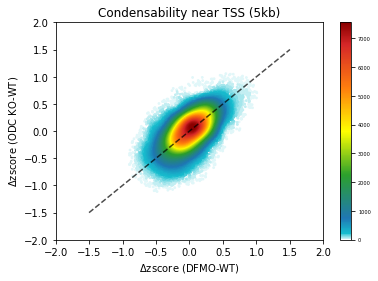

In [42]:
### plot dzscore vs dzscore plot
X, Y = [], []
for geneID in target_geneIDs:
    X.append(geneID_dzscore1[geneID])
    Y.append(geneID_dzscore2[geneID])

print
print "Spearman correlation"
print statis.get_spearman_corr(X, Y)
print

fig = plt.figure()
graphics.density_scatter(X, Y,
                         ax=plt.gca())
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k--', ms=2, alpha=0.7)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel("$\Delta$zscore (DFMO-WT)")
plt.ylabel("$\Delta$zscore (ODC KO-WT)")
plt.title("Condensability near TSS (5kb)")
#plt.savefig("zdscoreVSzdscore.png", dpi=500, bbox_inches='tight')
plt.show()
plt.close()